# Introduction

*Saccharomyces cerevisiae* is a yeast, a small single-cell eukaryote, known for its fermentation abilities. It has been used for winemaking, baking, and brewing since first emerging civilizations. Thanks to its characteristics, *Saccharomyces cerevisiae* is examined as a convenient model organism.

We are going to study its  gene regulatory network using graph theory and python **networkx** library.

# Exploration and characterization of the gene regulatory network

In [1]:
import networkx as ntx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz as pgv
ntx.__version__

'2.3'

The file *GRN_edges_S_cerevisiae.txt* contains the edges between transcription factors and target genes. We will use it to create our graph. We drop the first column which has no further interest.

In [2]:
network = pd.read_csv("GRN_edges_S_cerevisiae.txt", sep = ',', header=0)
gene = pd.read_table("net4_gene_ids.tsv", sep = '\t')
transcription= pd.read_table('net4_transcription_factors.tsv')
mapping = pd.read_table('go_slim_mapping.tab.txt', header = None)
network = network.drop('Unnamed: 0', axis=1)

We print every dataframe to see its content. *network* contains the relations between transcription factors and target genes, *gene* the name of genes within their ids, *transcription* the list of transcription factors. In *mapping*, we'll use the gene names (first column) and the Gene Ontology annotation (sixth column).

In [3]:
network.head()

,transcription_factor,target_gene
0,G15,G1
1,G98,G1
2,G109,G1
3,G22,G9
4,G211,G11


In [57]:
gene = gene.set_index('ID')
gene.head()

,Name
ID,
G1,YHR084W
G2,YER109C
G3,YDR496C
G4,YBR098W
G5,YNL139C


In [8]:
transcription.head()

,transcription_factor
0,G1
1,G2
2,G3
3,G4
4,G5


In [69]:
mapping.head()

,0,1,2,3,4,5,6
0,HRA1,HRA1,S000119380,C,cellular_component,GO:0005575,ncRNA_gene
1,HRA1,HRA1,S000119380,F,molecular_function,GO:0003674,ncRNA_gene
2,HRA1,HRA1,S000119380,P,rRNA processing,GO:0006364,ncRNA_gene
3,HRA1,HRA1,S000119380,P,ribosomal small subunit biogenesis,GO:0042274,ncRNA_gene
4,ICR1,ICR1,S000132612,C,nucleus,GO:0005634,ncRNA_gene


We create our directed graph. It contains 1994 nodes and 3940 edges with average in and out degree of 1.9759.

In [3]:
G = ntx.DiGraph()
G = ntx.from_pandas_edgelist(network, 'transcription_factor', 'target_gene', create_using = ntx.DiGraph())
ntx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 1994\nNumber of edges: 3940\nAverage in degree:   1.9759\nAverage out degree:   1.9759'

## Plotting the network

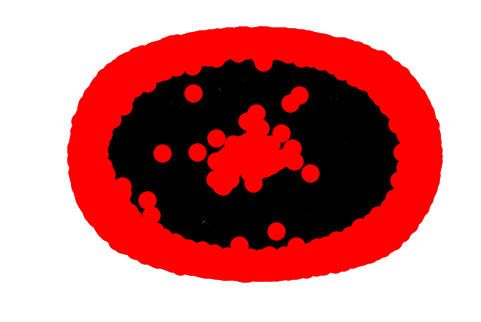

In [8]:
ntx.draw(G)

We draw the network using *draw()* method. This image is not really clear. In order to get a better representation of the graph, we have to find another method.

In [9]:
both_genes = set(network['transcription_factor']).intersection(network['target_gene'])
regulatory_genes = set(network['transcription_factor']) - set(both_genes)
target_genes = set(network['target_gene']) - set(both_genes)

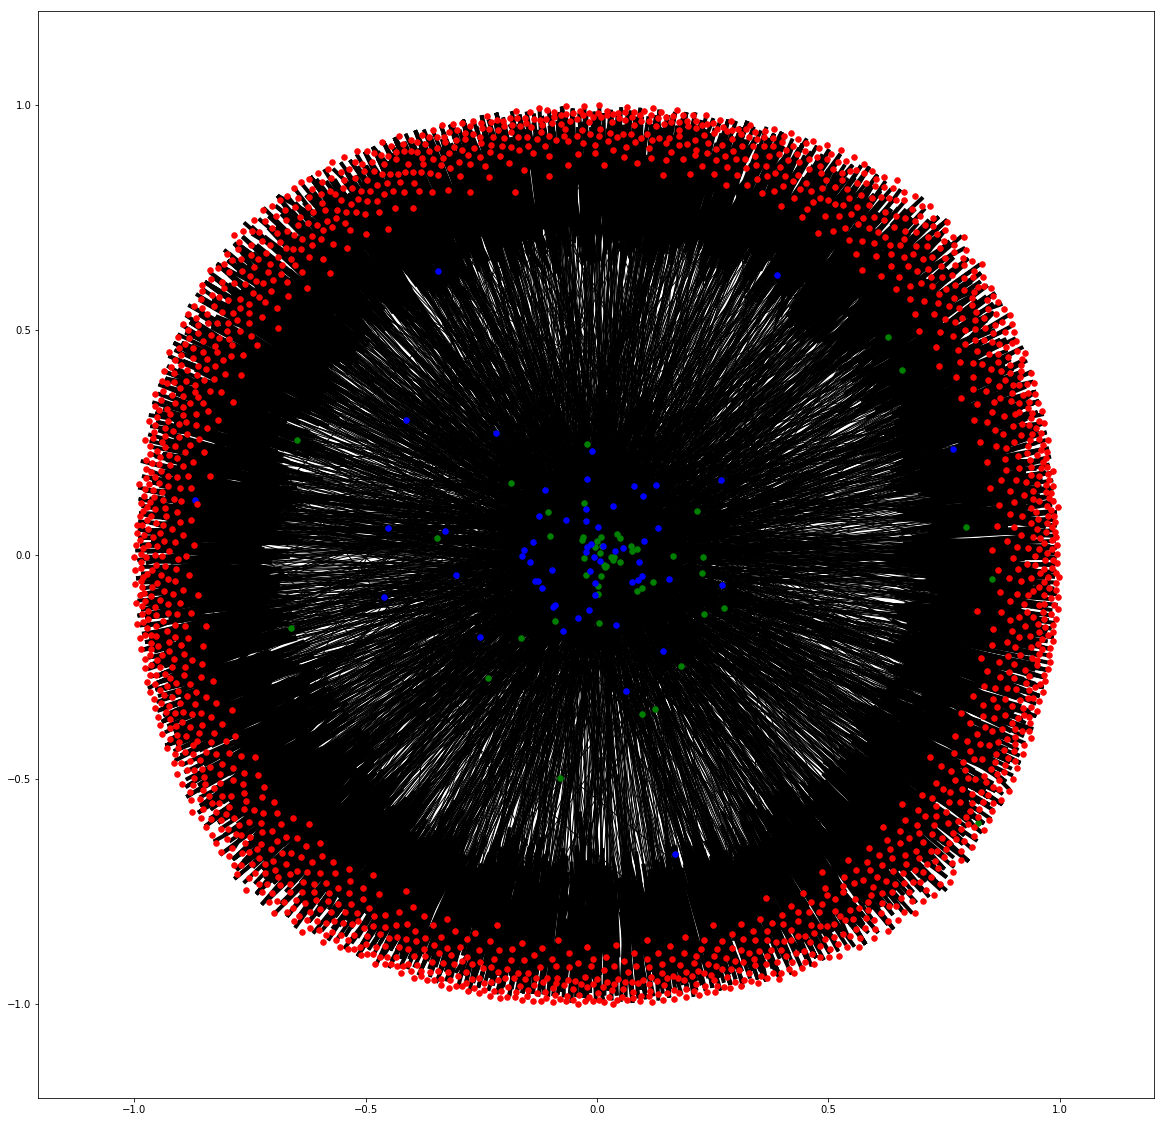

In [10]:
plt.figure(figsize=(20,20))
ntx.draw_networkx_edges(G, pos = ntx.spring_layout(G), edgelist = list(G.edges()))
ntx.draw_networkx_nodes(G, nodelist= list(both_genes), 
                       node_color = 'g',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), 
                       node_color = 'b',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist=list(target_genes) , 
                       node_color = 'r',  pos = ntx.spring_layout(G), with_labels = False, node_size = 30)

We can see that a central cluster of regulatory and both (target and regulatory) genes plays the main role in the network. Target genes form a red circle around this cluster, beeing at the end of the regulation cycle.

Even though this image, created using *ntx.spring_layout*, gives us a better idea about the disposition of factors and genes in the graph, we would like to get a shape that specifies if there are some particular parts in the graph. For that, we'll use the *nx_agraph.graphviz_layout* method.

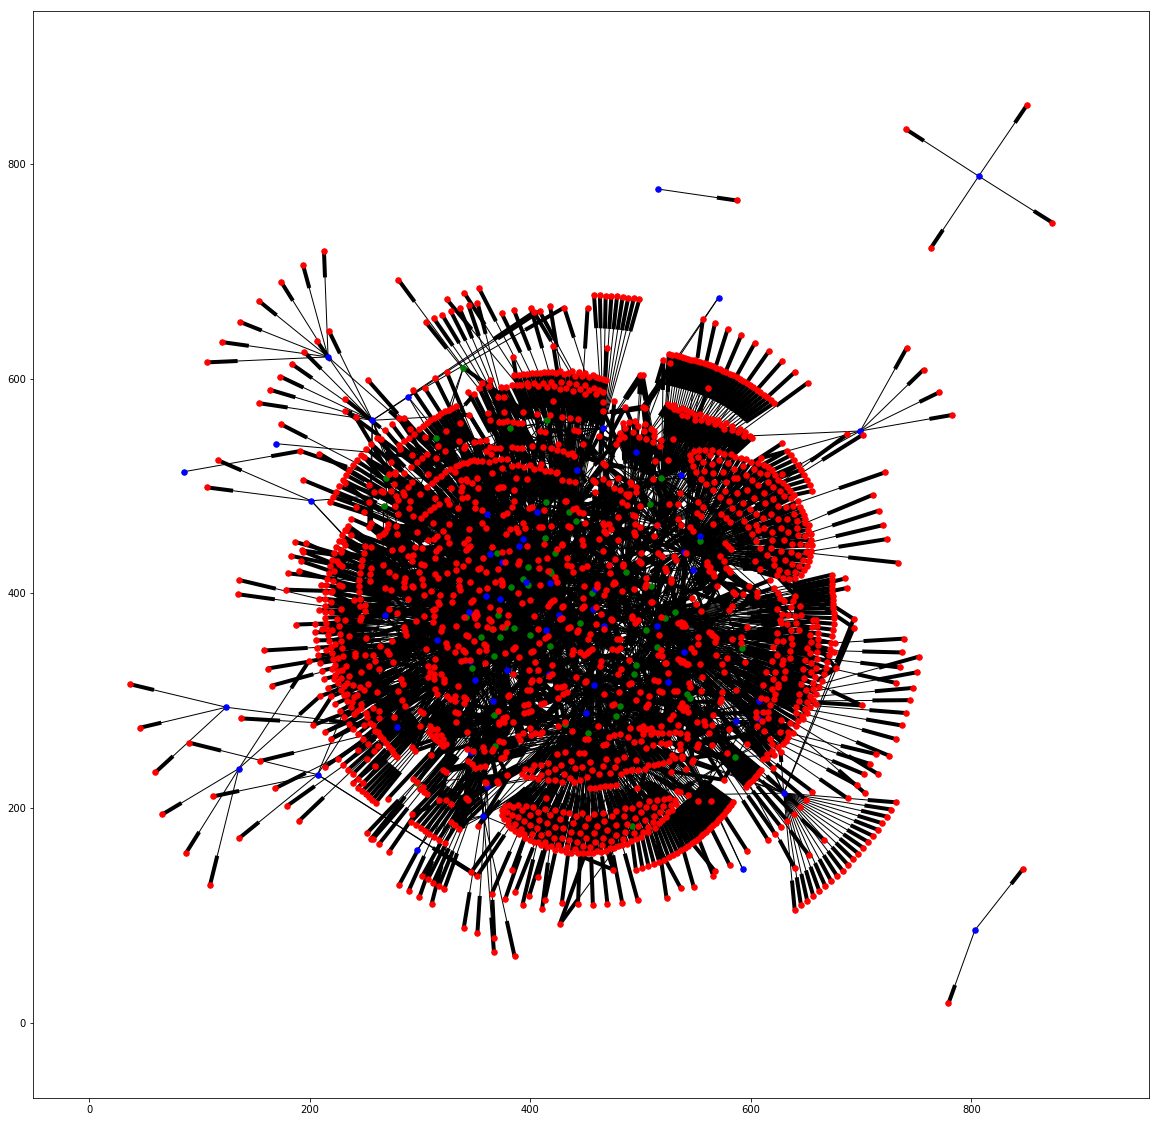

In [11]:
plt.figure(figsize=(20,20))
ntx.draw_networkx_edges(G, pos = ntx.nx_agraph.graphviz_layout(G), edgelist = list(G.edges()))
ntx.draw_networkx_nodes(G, nodelist= list(both_genes), node_color = 'g', \
                        pos = ntx.nx_agraph.graphviz_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist= list(regulatory_genes), node_color = 'b',  \
                        pos = ntx.nx_agraph.graphviz_layout(G), with_labels = False, node_size = 30)
ntx.draw_networkx_nodes(G, nodelist=list(target_genes) , node_color = 'r', \
                        pos = ntx.nx_agraph.graphviz_layout(G), with_labels = False, node_size = 30)

This representation shows the major links between the target genes only (red), transcription factors only (blue) and the genes that accomplish both roles (green). 

We see the structure of the network and distinguish the kinds of nodes. The dendogram hierarchy is also clear from this figure as we are able to see some levels of the regulatory tree. 
One factor often regulates a whole bunch of genes. In few cases, this relation is unconnected to the rest of the graph.  

We define a new method which allows us to use simply *nx_agraph.graphviz_layout()* and distinguish certain nodes.

In [12]:
def draw_agraph(G, nodes):
    plt.figure(figsize=(20,20))
    col = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fbff']
    ntx.draw_networkx_edges(G, pos = ntx.nx_agraph.graphviz_layout(G), edgelist = list(G.edges()))
    for i in range(len(nodes)):
        ntx.draw_networkx_nodes(G, pos = ntx.nx_agraph.graphviz_layout(G), \
                                nodelist = nodes[i], node_color = col[i], \
                                with_labels = False, node_size = 30)

## Network metrics

Network metrics help us characterize the main features of the graph.

#### Clustering coefficient

To calculate the clustering coefficient of a node, we use the following formula :

$C = {\frac {\mbox{number of closed triplets}}{\mbox{number of all triplets (open and closed)}}}$

In [13]:
clust_coef = ntx.average_clustering(G.to_undirected())
clust_coef

0.04436303023690503

The clustering coefficient measures the degree to which nodes in a graph tend to cluster together. In this graph, it is very low : around 0.044. The nodes are not very connected to each other to make clusters. This value matches the figure of our graph. We can see most of the nodes are leaves.

The brute method to calculate the clustering coefficient is for every node to find the neighboroud, and to find every neighbor's neighbor, to see if bucle up in a triangle. The complexity of this algorithm would be of $O(n^3)$.

#### Betweenness centrality

(array([1.973e+03, 4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.00010273, 0.00020546, 0.00030819, 0.00041092,
        0.00051365, 0.00061638, 0.00071911, 0.00082184, 0.00092457,
        0.00102729, 0.00113002, 0.00123275, 0.00133548, 0.00143821,
        0.00154094, 0.00164367, 0.0017464 , 0.00184913, 0.00195186,
        0.00205459]),
 <a list of 20 Patch objects>)

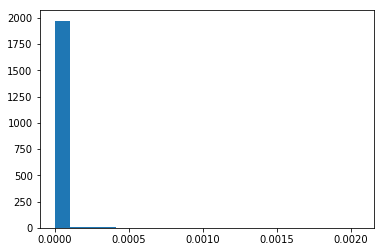

In [26]:
btw_ctr = ntx.betweenness_centrality(G)
plt.hist(btw_ctr.values(), bins=20)

Betweeness centrality is defined as the number of shortest paths, among any pair of nodes, passing by a given vertex (node). 

We can see that in our case it is often very low. Majority of nodes (cca 1973 of 1994) figure in a very small number of shortest paths (0 or 1). 

According to the networkx documentation, the betweenness centrality complexity of the python algorithm is $O(nm + n^2 log(n))$ (https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249).

#### Degrees in and out

In [35]:
adj_G = ntx.to_numpy_matrix(G, nodelist=G.nodes())
adjacency = pd.DataFrame(adj_G)
in_degree = adjacency.sum(axis=0).sort_values() 
out_degree = adjacency.sum(axis=1).sort_values() 

14.0


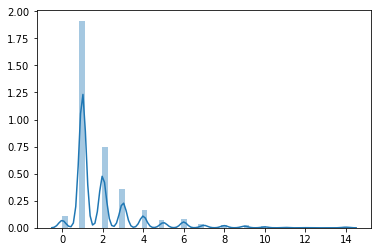

In [37]:
print(max(in_degree))
sns.distplot(in_degree)

The histogram of in-degree seems to follow the Chi-squared distribution. Most of the nodes have only one incoming edge (final point of the regulatory network). Quantity of nodes having others incoming edges decrease with the maximum of 14.

217.0


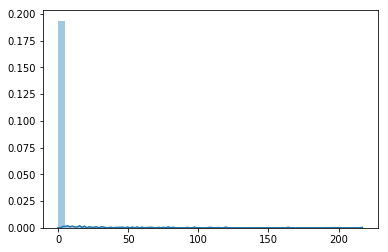

In [39]:
print(max(out_degree))
sns.distplot(out_degree)

As expected, majority of the network has no out-coming edge (corresponds to the target genes only). The regulation is thus compised in a small comunity of genes and factors (this was also clear in the plots). Maximum of the out-degree is 217, so there is a gene (factor) regulating 217 other genes!

The complexity of this algorithm is O(M), the number of edges. Indeed, to solve this algorithm, we start with null degree for every node. We have to cover every edge of the graph and for each one upgrade the degree of the each node (0(1)).

#### Density

$ D = \frac{\text{nb of edges}}{\text{max nb of edges}} = \frac{E}{N(N-1)}$

In [69]:
ntx.density(G)

0.0009914339103612895

As we can see, our graph is not dense at all, this is due to the vast majority of target genes that have only one incoming edge.

Because we have direct access to both the number of nodes and the number of edges, we have a complexity of O(1).

#### Closeness centrality

$H(X) = \Sigma_{x\ne y} \frac{1}{d(y,x)}$   

It is, for directed graphs, the sum of the reciprocal length of the shortest paths between the node and all other nodes in the graph.

To compute the closeness centrality of a node, we just have to run Djikstra's algorithm once to find the distance from a node to all other nodes. Thus, its complexity is O(E + Nln(N)).

(array([ 10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,
         10.,   8.,   3.,   8.,  34.,  46.,  37.,  53.,  40.,  97., 298.,
        222., 325., 264., 179., 125.,  76.,  60.,  32.,  18.,  15.,  18.,
          6.,   1.,   4.,   0.,   1.,   1.]),
 array([0.00050176, 0.00791199, 0.01532223, 0.02273247, 0.0301427 ,
        0.03755294, 0.04496317, 0.05237341, 0.05978365, 0.06719388,
        0.07460412, 0.08201436, 0.08942459, 0.09683483, 0.10424506,
        0.1116553 , 0.11906554, 0.12647577, 0.13388601, 0.14129625,
        0.14870648, 0.15611672, 0.16352696, 0.17093719, 0.17834743,
        0.18575766, 0.1931679 , 0.20057814, 0.20798837, 0.21539861,
        0.22280885, 0.23021908, 0.23762932, 0.24503955, 0.25244979,
        0.25986003, 0.26727026, 0.2746805 , 0.28209074, 0.28950097,
        0.29691121, 0.30432145, 0.31173168, 0.31914192, 0.32655215,
        0.33396239, 0.34137263, 0.34878286, 0.

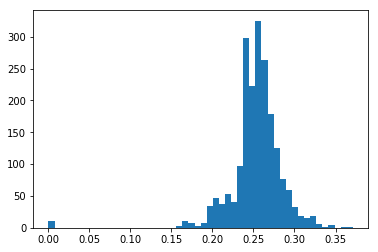

In [71]:
cc_cnt = ntx.closeness_centrality(G.to_undirected())
plt.hist(cc_cnt.values(),bins = 50)

Closeness centrality is a measure of centrality in a network. That means, the more central a node is, the closer it is to all other nodes. 

We observe a histogram of clossenes centralities of our graph. Few nodes have a CC of 0 - they are not connected to the rest. Majority of nodes have a CC about 0.25 so we need approximately 4 steps to pass from one node to any other in the network.
Several nodes are more central - we need only about 3 edges to get to any other node. We will show these nodes on a figure. 

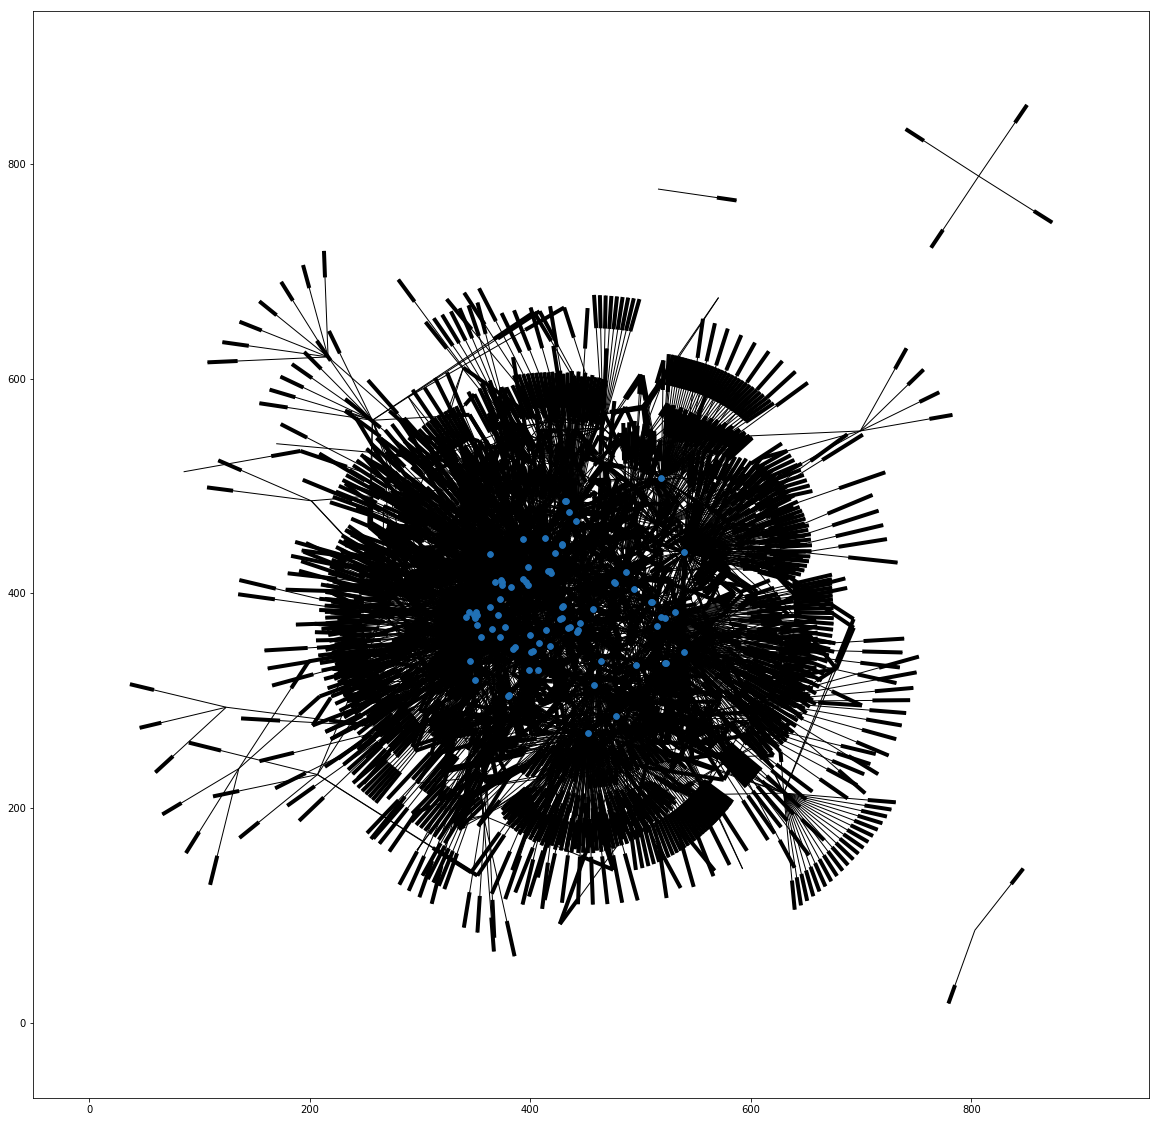

In [72]:
nodes_cc = [[]]*2
for n in G.nodes():
    if ntx.closeness_centrality(G.to_undirected(), n) > 0.32:
        nodes_cc[0].append(n)
    elif ntx.closeness_centrality(G.to_undirected(), n) > 0.30:
        nodes_cc[1].append(n)
draw_agraph(G, nodes_cc)

As presumed, these nodes are in the center of the network, regulating the rest of the genes.

The metrics allowed us to conclude about the general connectivity and closeness in the graph - the nodes are not densily connected but pretty close to each other. We can explain this thanks to the structure of regulation where only a bunch of nodes influences all the network.

## K-shell decomposition

K–shell (or k–core) decomposition is an algorithm for analyzing the structure of large–scale graphs. It provides a method for identifying hierarchies in a network. 

The *k-shell* instance provides us with a list of lists where the nodes in every layer has a degree corresponding to its index (and the nodes getting this degree by removing other nodes recursively).

The *k-core* instance is a list of lists containing the nodes surviving in the graph after the removal.

('k', 1)
('nb of nodes', 941)
('k', 2)
('nb of nodes', 524)
('k', 3)
('nb of nodes', 293)
('k', 4)
('nb of nodes', 184)
('k', 5)
('nb of nodes', 112)
('k', 6)
('nb of nodes', 55)
('k', 7)
('nb of nodes', 0)


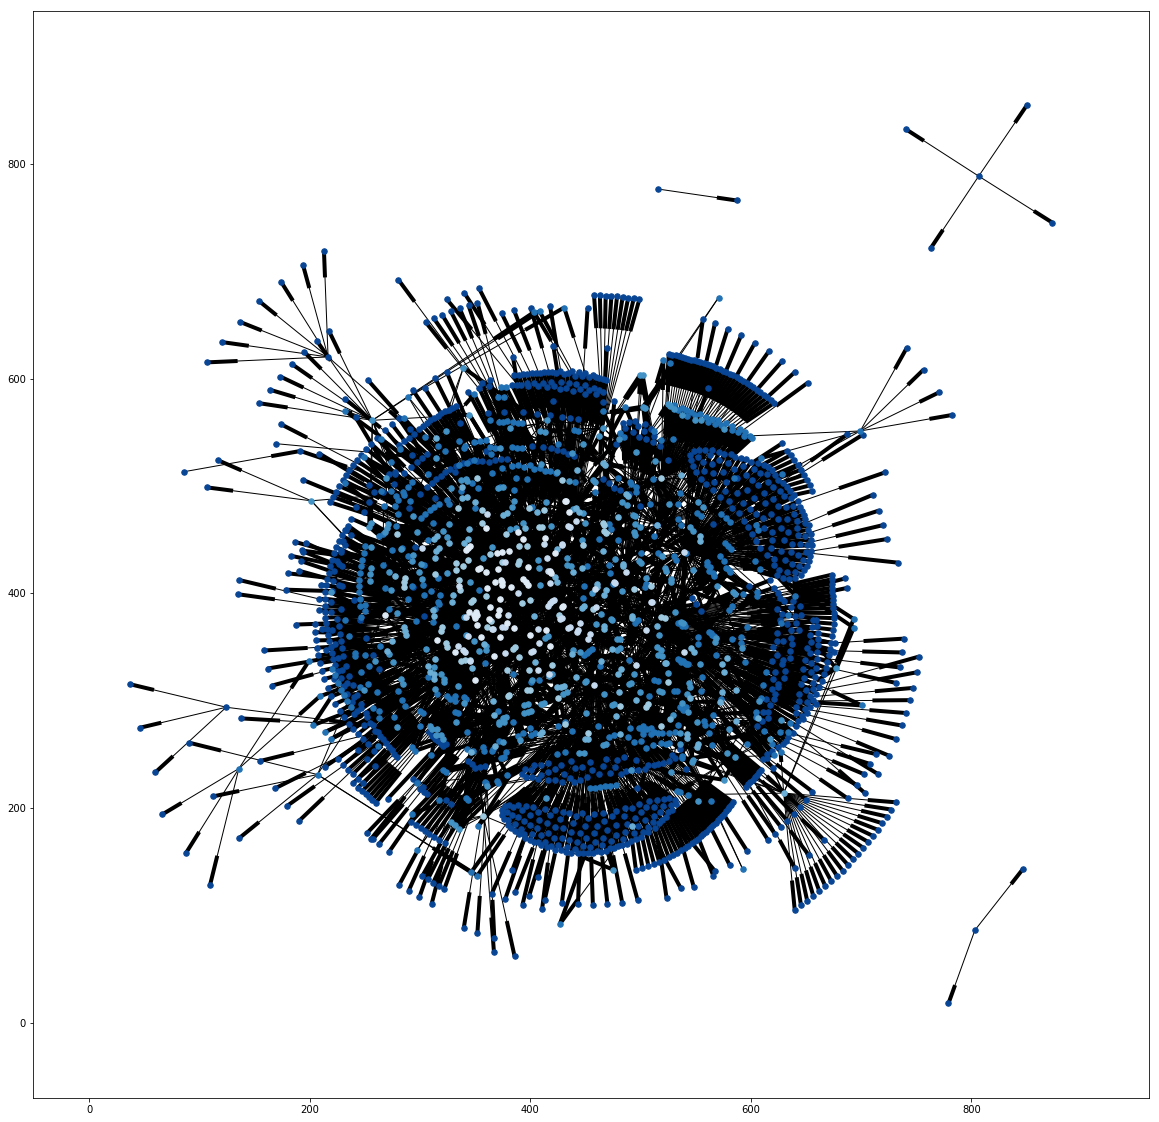

In [38]:
def k_shell(G):
    k = 1 
    G_ = G.copy() 
    k_shell = [] 
    k_core = [] 
    
    degrees = list(G_.degree()) 
    only_deg = []  
    for i in range(len(degrees)): 
        only_deg.append(degrees[i][1]) 
    
    while G_.number_of_nodes() > 0: 
        while True in [True for c in range(k+1) if c in only_deg]:
            for n, d in list(G_.degree()):
                if d <= k :
                    if len(k_shell) >= k:
                        k_shell[k-1].append(n)
                    else:
                        k_shell.append([n])
                    G_.remove_node(n)
            
            degrees = list(G_.degree())
            only_deg = []
            for i in range(len(degrees)):
                only_deg.append(degrees[i][1])
                
        k_core.append(list(G_.nodes()))
        print("k", k)
        print("nb of nodes", G_.number_of_nodes()) 
        k = k+1
    return k_core, k_shell
                
G_core = k_shell(G)[1]
draw_agraph(G, G_core)

Nodes colored in blue are in the first layers of the k-shell, they have been removed in first so they are not in the core of the graph. Nodes in white form the true heart of the graph - they have been removed in the last moments of the decomposition.

We can see that at every layer, the number of nodes is roughly divided by two. In the end, we get 55 nodes (in white) that form the true core of the graph. Blue nodes are the leafs of the dendogram.

# Community detection

### Girvan–Newman algorithm

The Girvan-Newman algorithm is a method used to find communities in complex graphs. The goal of this method is to identify the edges probably binding communities, and to remove them in order to get individual communities.

The algorithm works this way:
- calculate the betweenness of all edges in the graph
- remove the edges having the highest betweenness
- calculate again the betweenness of the edges 
- get back to the second and third step

Indeed, the first edges to be removed will have the highest betweenness, and so will be used a lot to make a shortest path between two nodes of the graph. We can say then that the edges are used as bridges between the different communities, and many are crossed to go from one side of the cluster to another.

In [5]:
import itertools

k = 1
comp = ntx.algorithms.community.centrality.girvan_newman(G)

In [7]:
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))
    list_comm = tuple(sorted(c) for c in communities)

(['G1', 'G100', 'G1000', 'G1001', 'G1008', 'G101', 'G1014', 'G1016', 'G1019', 'G102', 'G1028', 'G1029', 'G1031', 'G1033', 'G1035', 'G1039', 'G104', 'G1042', 'G1043', 'G1047', 'G1051', 'G1053', 'G1055', 'G1060', 'G1061', 'G1063', 'G1067', 'G1068', 'G1069', 'G107', 'G1070', 'G1071', 'G1073', 'G1076', 'G108', 'G1085', 'G109', 'G1092', 'G1094', 'G1097', 'G1099', 'G11', 'G110', 'G1103', 'G1104', 'G1105', 'G111', 'G1112', 'G1119', 'G112', 'G1125', 'G1127', 'G113', 'G1132', 'G1135', 'G1136', 'G1137', 'G1139', 'G1140', 'G1141', 'G1142', 'G1145', 'G1146', 'G115', 'G1158', 'G116', 'G1163', 'G1169', 'G117', 'G1175', 'G1183', 'G1186', 'G1187', 'G1189', 'G119', 'G1196', 'G12', 'G1204', 'G1206', 'G1208', 'G121', 'G1217', 'G122', 'G1221', 'G1227', 'G1229', 'G1230', 'G1232', 'G1236', 'G1237', 'G1238', 'G124', 'G1240', 'G1250', 'G1251', 'G1255', 'G1256', 'G1259', 'G126', 'G1264', 'G1265', 'G1266', 'G1267', 'G1269', 'G127', 'G1273', 'G1274', 'G128', 'G1280', 'G1293', 'G1296', 'G1297', 'G1298', 'G13', 'G

#### Time Complexity:

- number of steps: Each step of the algorithm continues until all edges have been removed. The number of steps is the number of edges E.
- Calculating the highest betweenness centrality for a graph with E nodes and N edges. Calculating  all the shortest paths (C=O(N * (N+E)ln(N))) and counting for every edge the number of paths, keeping track of the highest one. N is the number of nodes and (N+E)ln(N) the complexity of Djikstra algorithm to find all shortest paths starting from the same node. 

Conclusion: $C=O(E*N*(N+E)ln(N))$ in the worst case: $E=N^2. C=O(N^6ln(N))$

However, we found in literature (*L.Despalatovi, T.Vojkovie and Damir Vukicevie "Community structure in networks:Girvan-Newman algorithm improvement",MIPRO 2014, 26-30 May 2014, Opatija, Croatia*) ́that calculating the betweenness centrality for every edge has actually a complexity $C=O(EN)<O(N * (N+E)ln(N)))$ . The time complexity of Girvan–Newman algorithm is therefore :$C=O(E^2N)$ and in the worse case: $C=O(N^6)$.

['G1375', 'G220', 'G2303', 'G4322', 'G745'], 

['G1468', 'G1834', 'G184', 'G2263', 'G231', 'G2537', 'G2970', 'G4726', 'G4869']

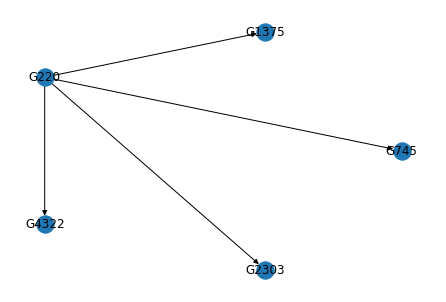

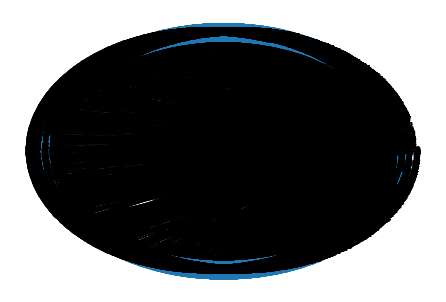

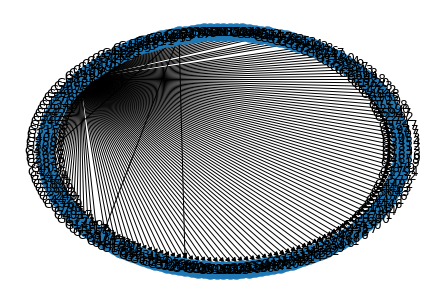

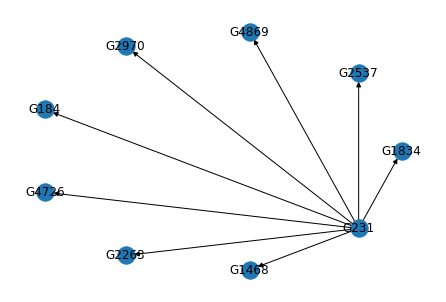

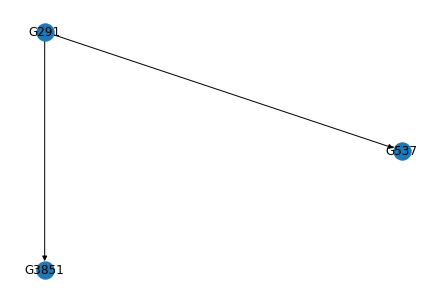

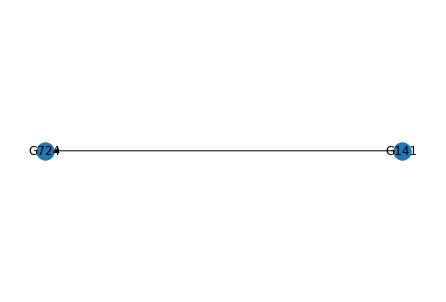

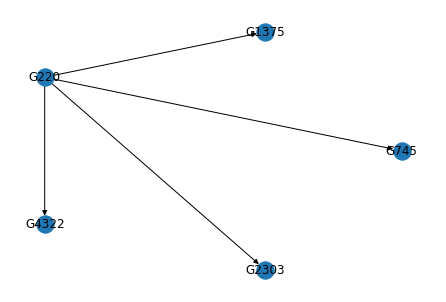

In [13]:
commun1 = G.subgraph(['G1375', 'G220', 'G2303', 'G4322', 'G745'])
ntx.draw_circular(commun1, with_labels= True)
for comm in list_comm:
    plt.figure()
    ntx.draw_circular(G.subgraph(comm), with_labels= True)

###  Louvain algorithm 

Louvain algorithm is a hierarchic method used for community detection based on optimization of modularity. Modularity is a value between -1 and 1 that measures the density of edges inside communities to edges outside communities.

In the Louvain Method, at first, small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated. 

In [106]:
import community
undi_G = G.to_undirected()
partition = community.best_partition(undi_G)
nb_com = max(partition.values())+1

#### Time complexity

If data structures are maintained such that each calculus of the modularity gain for one node when changing community can be computed in $O(1)$ time, the algorithm’s time complexity per iteration is $O(E)$, where E is the number of edges because each community variation corresponds to one edge, and every edge corresponds to two community variations (one for each of its nodes). 

We don't know how many iterations the algorithm needs to end (the modularity gain in null for each edge at the last iteration), but for most real network (including ones with billions of edges) this number is inferior to 10 so we can assume that the louvain algorithme is $O(E)$.

ref: *Lu Hao, Mahantesh Halappanavar, and Ananth Kalyanaraman "Parallel heuristics for scalable community detection*


In [107]:
d_names = {}
for key in partition:
    for g in list(gene.index):
        if g == key:
            d_names[gene.get_value(g,'Name')] = partition[key]
len(d_names)

C:\Computations\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


1994

In [172]:
df = pd.DataFrame(np.zeros((len(set(mapping[5])), nb_com)), \
                  index = list(set(mapping[5])), columns=[i for i in range(nb_com)])
df = df.drop(df.index[0], axis=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
GO:0016050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0006970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0003735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0016197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0016798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
for i in range(len(mapping[5])):
    if mapping[0][i] in d_names:
        if isinstance(mapping[5][i], str):
            j = d_names[mapping[0][i]]
            df[j][mapping[5][i]] += 1
    
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
GO:0016050,2.0,6.0,8.0,0.0,2.0,12.0,0.0,4.0,4.0,4.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0
GO:0006970,18.0,14.0,12.0,4.0,4.0,6.0,10.0,6.0,4.0,6.0,0.0,0.0,4.0,4.0,2.0,0.0,0.0,0.0
GO:0003735,2.0,10.0,4.0,0.0,2.0,8.0,2.0,4.0,106.0,2.0,2.0,4.0,16.0,0.0,2.0,0.0,0.0,0.0
GO:0016197,4.0,2.0,0.0,0.0,0.0,8.0,0.0,12.0,2.0,6.0,2.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0
GO:0016798,8.0,2.0,4.0,2.0,2.0,2.0,0.0,2.0,2.0,6.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [206]:
len(mapping[5])-sum(df.sum())

15085.0

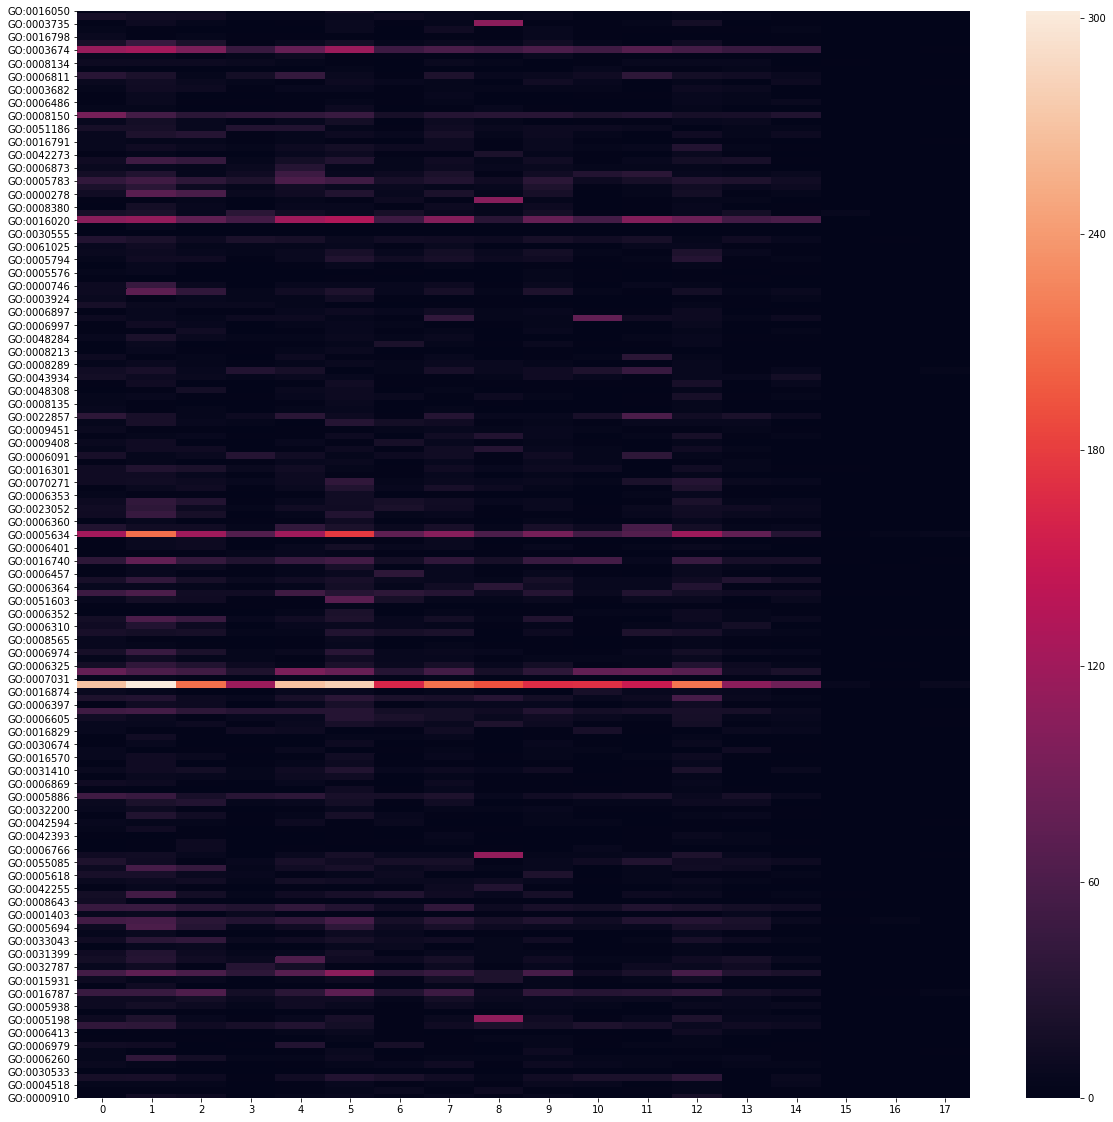

In [207]:
plt.figure(figsize=(20,20))
sns.heatmap(df)

In [208]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
GO:0016050,2.0,6.0,8.0,0.0,2.0,12.0,0.0,4.0,4.0,4.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0
GO:0006970,18.0,14.0,12.0,4.0,4.0,6.0,10.0,6.0,4.0,6.0,0.0,0.0,4.0,4.0,2.0,0.0,0.0,0.0
GO:0003735,2.0,10.0,4.0,0.0,2.0,8.0,2.0,4.0,106.0,2.0,2.0,4.0,16.0,0.0,2.0,0.0,0.0,0.0
GO:0016197,4.0,2.0,0.0,0.0,0.0,8.0,0.0,12.0,2.0,6.0,2.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0
GO:0016798,8.0,2.0,4.0,2.0,2.0,2.0,0.0,2.0,2.0,6.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0030533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0007005,18.0,20.0,10.0,2.0,14.0,28.0,22.0,14.0,4.0,14.0,22.0,22.0,36.0,0.0,8.0,0.0,0.0,0.0
GO:0004518,4.0,4.0,4.0,0.0,2.0,6.0,2.0,4.0,2.0,8.0,6.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0
GO:0006414,2.0,2.0,2.0,0.0,2.0,4.0,8.0,2.0,10.0,2.0,0.0,2.0,4.0,0.0,2.0,0.0,0.0,0.0


In [209]:
df.loc['GO:0005634']
df = df.drop('GO:0005634')
df.loc['GO:0005737']
df = df.drop(['GO:0005737', 'GO:0003674', 'GO:0016020'])

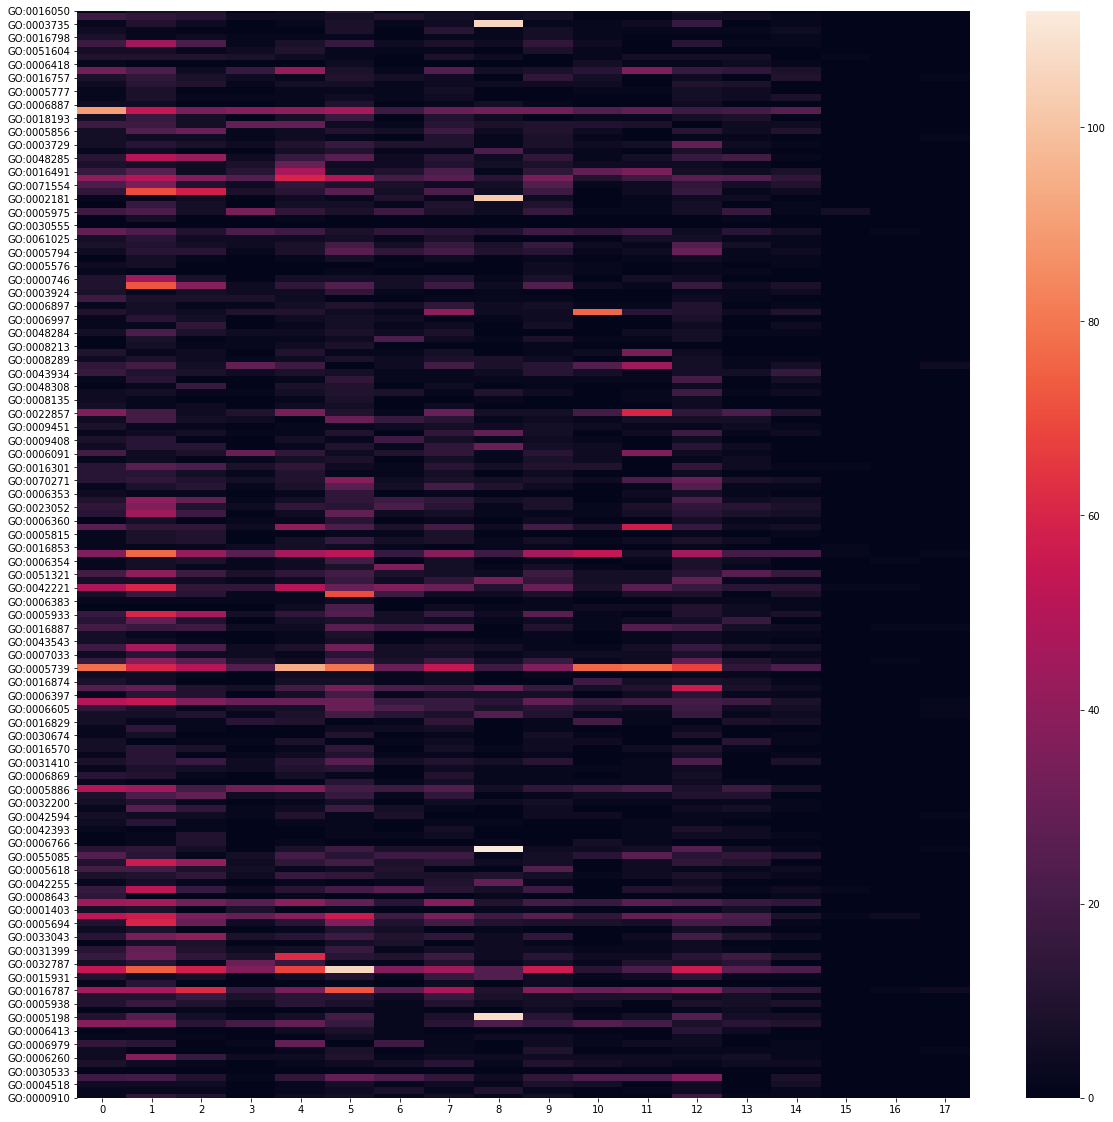

In [210]:
plt.figure(figsize=(20,20))
sns.heatmap(df)

# Conclusion